# Lab Four: The Multi-Layer Perceptron

Team: Miro Ronac, Kirk Watson, Brandon Vincitore

## 1. Load, Split, and Balance

### Load Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#Load the data into memory and save it to a pandas data frame
df = pd.read_csv('acs2017_census_tract_data.csv')
print('Dataset Size:', df.shape[0])
#Remove any observations that having missing data
df.dropna(inplace=True)
print('Size after removing missing data:', df.shape[0])
#Encode any string data as integers
print('Columns to encode as integers: ', df.select_dtypes(include='object').columns[0],df.select_dtypes(include='object').columns[1])
for col in df.select_dtypes(include='object').columns:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])
    
#Remove non-continuous numeric feature data and others
continuous_features = list(df.columns)
for col in set(["ChildPoverty", "TractId", "State", "County"]):
    continuous_features.remove(col)
    
#Set y as child poverty rate and remove unneeded columns
y = df.ChildPoverty
X = df.drop(["ChildPoverty", "TractId", "County"], axis=1)
X.head()

Dataset Size: 74001
Size after removing missing data: 72718
Columns to encode as integers:  State County


,State,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,0,1845,899,946,2.4,86.3,5.2,0.0,1.2,0.0,...,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,0,2172,1167,1005,1.1,41.6,54.5,0.0,1.0,0.0,...,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,0,3385,1533,1852,8.0,61.4,26.5,0.6,0.7,0.4,...,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,0,4267,2001,2266,9.6,80.3,7.1,0.5,0.2,0.0,...,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,0,9965,5054,4911,0.9,77.5,16.4,0.0,3.1,0.0,...,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3


We removed the ChildPoverty feature because that was our prediction task. The County feature was removed to allow our neural net to converge. The TractId feature was dropped because that was irrelevant data.

### Split Dataset

In [2]:
from sklearn.model_selection import train_test_split

#Split the dataset into 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(),
                                                    test_size=.20, random_state=42)
print("Training Set Size:",X_train.shape)
print("Testing Set Size:",X_test.shape)

Training Set Size: (58174, 34)
Testing Set Size: (14544, 34)


### Balance Dataset

In [3]:
# Balance the dataset so that about the same number of instances are within each class
y_train, bins = pd.qcut(y_train, q=4, labels=[0,1,2,3], retbins=True) # constructing 4 classification levels
print("Bin Quartile Ranges:",bins)

Bin Quartile Ranges: [  0.    6.2  16.4  31.7 100. ]


We balanced the dataset above by identifying 4 quartile ranges using a quantile-based discretization function from Pandas. This function is able to create equal-sized buckets of observations based on the "ChildPoverty" feature. This method utilized to balance the dataset creates an accurate representation of the entire dataset which is necessary when training our classifier.

Training Bin Class Sizes: [14596 14580 14476 14522]


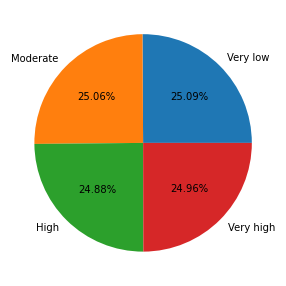

Here we can see that we did a good job of balancing our quantization for the training set.


In [4]:
# Output number of instances and plot
print("Training Bin Class Sizes:",np.bincount(y_train))
fig = plt.figure(figsize=(5, 5))
plt.pie(np.bincount(y_train),
        labels=['Very low', 'Moderate', 'High', 'Very high'],
        autopct='%.2f%%')
plt.show()
print('Here we can see that we did a good job of balancing our quantization for the training set.')

Test Bin Class Sizes: [3633 3753 3599 3559]


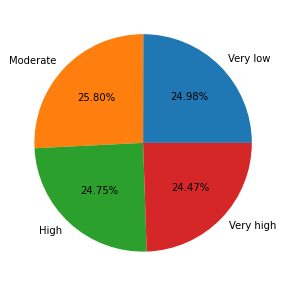

Here we can see that our test set is also balanced relatively well.


In [5]:
y_test = pd.cut(y_test, bins, labels=[0,1,2,3], include_lowest=True)
print("Test Bin Class Sizes:",np.bincount(y_test))
fig = plt.figure(figsize=(5, 5))
plt.pie(np.bincount(y_test),
        labels=['Very low', 'Moderate', 'High', 'Very high'],
        autopct='%.2f%%')
plt.show()
print('Here we can see that our test set is also balanced relatively well.')

In most cases, the testing set should not be balanced while the training set should be balanced. The training set should be balanced to avoid creating biases to over-represented or under-represented classes when training the classifier. Not balancing the testing set allows for a true performance evaluation of the classifier. Testing sets represent untampered data that the classifier might experience in the real world. A balanced testing set is unrealistic and can introduce bias. We will have to work with a balanced test dataset because we need to be able to classify the test dataset within the same child poverty rate ranges as our training set (i.e., the bounds we set on each poverty rate needs to remain the same throughout our model to avoid misclassification).

## 2. Pre-processing
### Starting with simple base classifier

In [6]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka

import numpy as np
from scipy.special import expit
import pandas as pd
import sys

#A simple base classifier, which can't be fit or predicted
#Only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0,size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        """
        A1 = self._add_bias_unit(X, how='column')
        A1 = A1.T
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)  # last layer sensitivity
        V1 = A2*(1-A2)*(W2.T @ V2) # back prop the sensitivity 
        
        grad2 = V2 @ A2.T # no bias on final layer
        grad1 = V1[1:,:] @ A1.T # dont back prop sensitivity of bias
        
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred

### Add mini-batch to vectorized TLP

In [7]:
# Example from https://github.com/eclarson/MachineLearningNotebooks/blob/master/08.%20Practical_NeuralNets.ipynb
from sklearn.metrics import accuracy_score

class TLPMiniBatch(TwoLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        rho_W1_prev = np.zeros(self.W1.shape)
        rho_W2_prev = np.zeros(self.W2.shape)

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        for i in range(self.epochs):

            # adaptive learning rate
            # \frac{\eta}{1+\epsilon\cdot k}
            eta = self.eta / (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2)
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                # momentum calculations
                rho_W1, rho_W2 = eta * grad1, eta * grad2
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev))
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev))
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        return self

### Now implement cross entropy by updating cost function and change V2 in gradient calculation

In [8]:
# Example from https://github.com/eclarson/MachineLearningNotebooks/blob/master/08.%20Practical_NeuralNets.ipynb
class TLPMiniBatchCrossEntropy(TLPMiniBatch):
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = (A3-Y_enc) # <- this is only line that changed
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2

### Last step is proper utilization of Glorot initialization

In [9]:
# Example from https://github.com/eclarson/MachineLearningNotebooks/blob/master/08.%20Practical_NeuralNets.ipynb
class TLPBetterInitial(TLPMiniBatchCrossEntropy):             
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)) 
        W2[:,:1] = 0
        
        return W1, W2

### Quantify Performance

In [10]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

def print_result(nn,X_train,y_train,X_test,y_test,title="",color="red"):
    
    print("=================")
    print(title,":")
    yhat = nn.predict(X_train)
    print('Resubstitution acc:',accuracy_score(y_train,yhat))
    
    yhat = nn.predict(X_test)
    print('Validation acc:',accuracy_score(y_test,yhat))
    
    if hasattr(nn,'val_score_'):
        plt.plot(range(len(nn.val_score_)), nn.val_score_, color=color,label=title)
        plt.ylabel('Validation Accuracy')
    else:
        plt.plot(range(len(nn.score_)), nn.score_, color=color,label=title)
        plt.ylabel('Resub Accuracy')
        
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)

Epoch: 50/50

CPU times: total: 2min 44s
Wall time: 13.7 s
Not normalized or one-hot encoded data :
Resubstitution acc: 0.24954447003816138
Validation acc: 0.24443069306930693


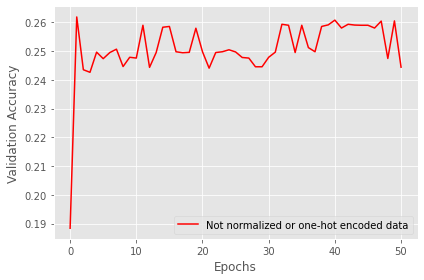

In [11]:
vals = { 'n_hidden':30, 
         'C':0.1, 'epochs':50, 'eta':0.001, 
         'alpha':0.001, 'decrease_const':1e-5, 'minibatches':50,
         'shuffle':True,'random_state':1}
#quantify performance using accuracy
nn = TLPBetterInitial(**vals)

%time nn.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))

print_result(nn,X_train,y_train,X_test,y_test,title="Not normalized or one-hot encoded data")
plt.show()

### Normalize continuous numeric feature data

Epoch: 50/50

CPU times: total: 50.9 s
Wall time: 4.27 s
Normalized continuous data :
Resubstitution acc: 0.6061814556331007
Validation acc: 0.6009350935093509


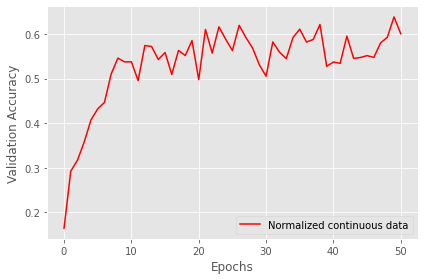

In [12]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()

#normalize continuous numeric feature data
X_normal = X.copy()
X_normal[continuous_features] = standard_scaler.fit_transform(X_normal[continuous_features])
#get training and testing set
X_train_normal, X_test_normal = train_test_split(X_normal.to_numpy(),
                                                    test_size=.20,
                                                    random_state=42)
#quantify performance using accuracy
nn = TLPBetterInitial(**vals)

%time nn.fit(X_train_normal, y_train, print_progress=1, XY_test=(X_test_normal, y_test))

print_result(nn,X_train_normal,y_train,X_test_normal,y_test,title="Normalized continuous data")
plt.show()

### Normalize continuous numeric feature data AND one hot encode categorical data

Epoch: 50/50

CPU times: total: 1min 8s
Wall time: 5.7 s
Normalized and one-hot encoded data :
Resubstitution acc: 0.7356035342249114
Validation acc: 0.7317106710671067


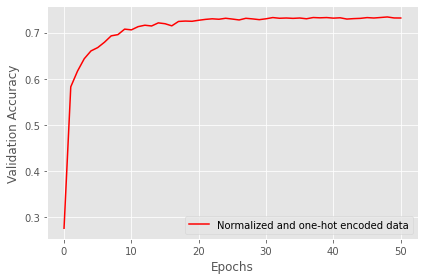

In [13]:
#get normalized continuous data
X_normal_encoded = X_normal.copy()
#one-hot encode categorical data aka "State" column
X_normal_encoded = pd.concat([X_normal_encoded, pd.get_dummies(X_normal_encoded["State"], prefix="State")],axis=1)
X_normal_encoded.drop(["State"], axis=1, inplace=True)
#get training and testing set
X_train_norm_enc, X_test_norm_enc = train_test_split(X_normal_encoded.to_numpy(),
                                                    test_size=.20,
                                                    random_state=42)
#quantify performance using accuracy
nn = TLPBetterInitial(**vals)

%time nn.fit(X_train_norm_enc, y_train, print_progress=1, XY_test=(X_test_norm_enc, y_test))

print_result(nn,X_train_norm_enc,y_train,X_test_norm_enc,y_test,title="Normalized and one-hot encoded data")
plt.show()

### Compare performance of three models

Compared to the other models, the model using the unedited dataset had the lowest performance. With 4 identification classes and accuracy of about 25%, this model performed similar to how a random class picker would perform. The low performance can be attributed to the raw dataset which has many features with wide ranges of variabilities. As a result, the model struggled to learn and successfully identify classes.

The second model utilized a dataset that normalized continuous numeric features. This modification of the dataset allowed the model to have an increased performance of 60% accuracy, because normalizing the data removed the high variability in each of the continuous numeric features.

The third model had the best performance with an accuracy of 73%. In addition to using normalized continuous data, this dataset had categorical data one-hot encoded. The "State" feature was the only categorical feature, but it had a wide range of values to account for all 50 states. One-hot encoding the states created binary features for each state which reduced bias to the original "State" categorical feature. After evaluating these models, normalizing continuous numeric features and one-hot encoding categorical features is necessary to have optimal performance.

## 3. Modeling

### Add support for third layer in multi-layer perceptron

#### Starting with simple base classifier

In [14]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka

import numpy as np
from scipy.special import expit
import pandas as pd
import sys

#A simple base classifier, which can't be fit or predicted
#Only has internal classes to be used by classes that will subclass it
class MultiLayerPerceptronBase(object):
    def __init__(self, n_hidden=30, layers=3,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.layers=layers
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        W=[]
        """Initialize weights with small random numbers."""
        #initialize first weights
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0,size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        W.append(W1)
        #initialize middle weights
        for i in range(self.layers - 2):
            W_num_elems = (self.n_features_ + 1)*self.n_hidden
            W_middle = np.random.uniform(-1.0, 1.0,size=W_num_elems)
            W_middle = W_middle.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W CHECK HERE CHECK HERE
            W.append(W_middle)
        #initialize last weights
        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        W.append(W2)
        
        return W
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new 

    @staticmethod
    def _L2_reg(lambda_, W):
        """Compute L2-regularization cost"""
        #only compute for non-bias terms
        #from each layer get weight total
        weight_total=0
        for weight in W:
            weight_total += np.mean(weight[:, 1:] ** 2)
        return (lambda_/2.0) * np.sqrt(weight_total)
        
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))

    def _cost(self,A,Y_enc,W):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num(Y_enc*np.log(A[len(A) - 1])+(1-Y_enc)*np.log(1-A[len(A) - 1])))
        L2_term = self._L2_reg(self.l2_C, W)
        return cost + L2_term
      
    def _feedforward(self, X, W):
        """Compute feedforward step
        """
        A = []
        Z = []
        #feed foward first layer
        A.append(self._add_bias_unit(X, how='column').T)
        #feed forward middle layers
        for layer in range(self.layers - 1):
            Z.append(W[layer] @ A[layer])
            A_middle = self._sigmoid(Z[layer])
            A_middle = self._add_bias_unit(A_middle, how='row')
            A.append(A_middle)
        #feed forward last/output layer
        Z.append(W[len(W) - 1] @ A[len(A) - 1])
        A.append(self._sigmoid(Z[len(Z) - 1]))
        return A, Z

    def predict(self, X):
        """Predict class labels"""
        A, _ = self._feedforward(X, self.W)
        y_pred = np.argmax(A[len(A) - 1], axis=0)
        return y_pred

### Add mini-batch to vectorized MLP

In [15]:
# Example from https://github.com/eclarson/MachineLearningNotebooks/blob/master/08.%20Practical_NeuralNets.ipynb
from sklearn.metrics import accuracy_score

class MLPMiniBatch(MultiLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W = self._initialize_weights()

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        #For each epoch store gradiant averages
        gradient_averages = []
        for _ in range(self.layers):
            gradient_averages.append([])
            
        for i in range(self.epochs):

            # adaptive learning rate
            # \frac{\eta}{1+\epsilon\cdot k}
            #eta = self.eta / (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            
            #For each mini batch, store gradiant averages
            gradients = []
            for _ in range(self.layers):
                gradients.append([])
            
            for idx in mini:

                # feedforward
                A, Z = self._feedforward(X_data[idx], self.W)
                
                cost = self._cost(A, Y_enc[:, idx], self.W)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradient = self._get_gradient(A, Z, Y_enc[:, idx], self.W)
                
                #for each minibatch layer, get average gradient magnitudes
                for index in range(len(gradient)):
                    gradients[index].append(np.mean(gradient[index]))
                
                for index in range(len(gradient)):
                    self.W[index] -= (self.eta * gradient[index])

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
                
            #get average magnitude of the gradient for each layer
            for index in range(len(gradient_averages)):
                gradient_averages[index].append(np.mean(gradients[index]))
            
        return gradient_averages

### Now implement cross entropy by updating cost function and change V in gradient calculation

In [16]:
# Adapted example from https://github.com/eclarson/MachineLearningNotebooks/blob/master/08.%20Practical_NeuralNets.ipynb
class MLPMiniBatchCrossEntropy(MLPMiniBatch):
    def _cost(self,A,Y_enc,W):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num(Y_enc*np.log(A[len(A) - 1])+(1-Y_enc)*np.log(1-A[len(A) - 1])))
        L2_term = self._L2_reg(self.l2_C, W)
        return cost + L2_term

    def _get_gradient(self, A, Z, Y_enc, W):
        """ Compute gradient step using backpropagation.
        """
        gradients = [0] * self.layers
        V = [0] * self.layers

        #vectorized backpropagation, starting with last gradient
        V[-1] = A[-1] - Y_enc
        gradients[-1] = V[-1] @ A[-2].T
        gradients[-1][:, 1:] += W[-1][:, 1:] * self.l2_C
        
        #get gradients from last to first
        for i in reversed(range(self.layers-1)):
            V[i] = A[i+1]*(1-A[i+1])*(W[i+1].T @ V[i+1])
            gradients[i] = V[i][1:,:] @ A[i].T
            gradients[i][:, 1:] += W[i][:, 1:] * self.l2_C
            V[i] = V[i][1:,:]
        
        return gradients

### Last step is proper utilization of Glorot initialization

In [17]:
# Adapted example from https://github.com/eclarson/MachineLearningNotebooks/blob/master/08.%20Practical_NeuralNets.ipynb
class MLPBetterInitial(MLPMiniBatchCrossEntropy):
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        W = []
        #initialize weights for first layer
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W.append(np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1)))
        W[0][:,:1] = 0
        #initialize weights for middle layers
        for i in range(self.layers-2):
            init_bound = 4*np.sqrt(6. / (2*self.n_hidden + 1))
            W.append(np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_hidden + 1)))
            W[len(W) - 1][:,:1] = 0
        #initialize weights for first layer
        init_bound = 4*np.sqrt(6. / (self.n_output_ + self.n_hidden + 1))
        W.append(np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)))
        W[-1][:,:1] = 0
        
        return W

### Quantify Performance for 3 layers in multi-layer perceptron

In [18]:
%matplotlib inline

plt.style.use('ggplot')

def print_result(nn,X_train,y_train,X_test,y_test,gradients,title="",color="red"):
    
    print("=================")
    print(title,":")
    yhat = nn.predict(X_train)
    print('Resubstitution acc:',accuracy_score(y_train,yhat))
    
    yhat = nn.predict(X_test)
    print('Validation acc:',accuracy_score(y_test,yhat))
    
    #display accuracy performance
    if hasattr(nn,'val_score_'):
        plt.plot(range(len(nn.val_score_)), nn.val_score_, color=color,label=title)
        plt.ylabel('Validation Accuracy')
    else:
        plt.plot(range(len(nn.score_)), nn.score_, color=color,label=title)
        plt.ylabel('Resub Accuracy')
        
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    
    #display average gradient magnitudes for each layer
    for i in range(len(gradients)):
        plt.plot(range(len(gradients[0])), 
             gradients[i], 
             label="Gradient "+str(i + 1)) 
        
    plt.ylabel('Average Gradient Magnitudes')     
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

Epoch: 50/50

CPU times: total: 1min 26s
Wall time: 7.28 s
3 Layer Perceptron :
Resubstitution acc: 0.7360676590916905
Validation acc: 0.7314356435643564


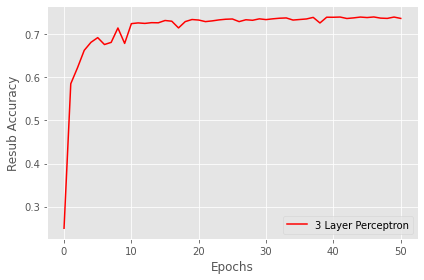

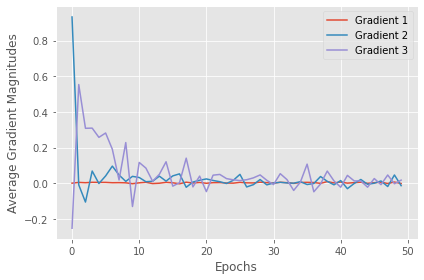

In [19]:
vals = { 'layers':3, 'n_hidden':30, 
         'C':0.1, 'epochs':50, 'eta':0.001, 
         'alpha':0.001, 'decrease_const':1e-5, 'minibatches':50,
         'shuffle':True,'random_state':1}

#quantify performance using accuracy
nn = MLPBetterInitial(**vals)
%time gradients = nn.fit(X_train_norm_enc, y_train, print_progress=1)
#display accuracy performance and average gradient magnitudes for each layer
print_result(nn,X_train_norm_enc,y_train, X_test_norm_enc, y_test,gradients,title="3 Layer Perceptron")

### Add support for 4 layers in multi-layer perceptron

Epoch: 50/50

CPU times: total: 1min 56s
Wall time: 9.75 s
4 Layer Perceptron :
Resubstitution acc: 0.7354316361261044
Validation acc: 0.7314356435643564


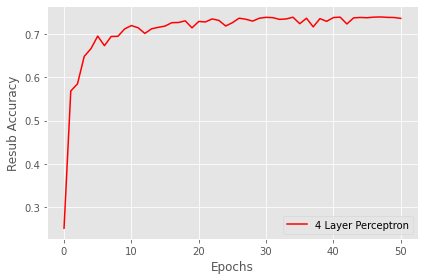

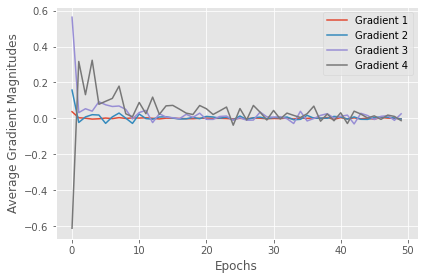

In [20]:
vals['layers'] = 4
#quantify performance using accuracy
nn = MLPBetterInitial(**vals)
%time gradients = nn.fit(X_train_norm_enc, y_train, print_progress=1)
#display accuracy performance and average gradient magnitudes for each layer
print_result(nn,X_train_norm_enc,y_train, X_test_norm_enc, y_test,gradients,title="4 Layer Perceptron")

### Add support for 5 layers in multi-layer perceptron

Epoch: 50/50

CPU times: total: 2min 20s
Wall time: 11.8 s
5 Layer Perceptron :
Resubstitution acc: 0.7370646680647712
Validation acc: 0.7323294829482948


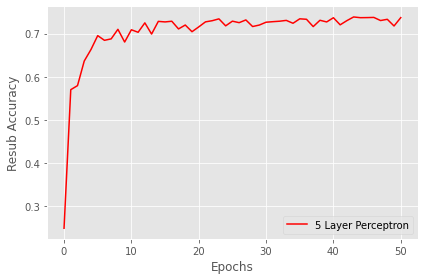

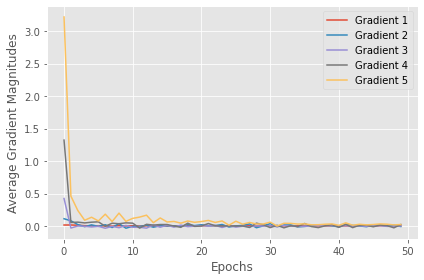

In [21]:
vals['layers'] = 5
#quantify performance using accuracy
nn = MLPBetterInitial(**vals)
%time gradients = nn.fit(X_train_norm_enc, y_train, print_progress=1)
#display accuracy performance and average gradient magnitudes for each layer
print_result(nn,X_train_norm_enc,y_train, X_test_norm_enc, y_test,gradients,title="5 Layer Perceptron")

### Implement adaptive learning technique

In [22]:
#Using AdaGrad adaptive learning formula from slides https://github.com/eclarson/MachineLearningNotebooks/blob/master/PDF_Slides/current%20slides/ML_5d_adaptive_learning.pdf
class AdaGradMLP(MLPBetterInitial):
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W = self._initialize_weights()
        
        #create AdaGrad variables
        G_k_prev = 0
        G_k_W = []
        rho_W_prev = []
        for weight in self.W:
            G_k_W.append(np.zeros(weight.shape))
            rho_W_prev.append(np.zeros(weight.shape))

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        
        #For each epoch store gradiant averages
        gradient_averages = []
        for _ in range(self.layers):
            gradient_averages.append([])
            
        for i in range(self.epochs):
            
            # adaptive learning rate
            # \frac{\eta}{1+\epsilon\cdot k}
            # use decrease_const as epsilon in AdaGrad formula
            eta = self.eta / (1 + self.decrease_const*i)
            
            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            
            #For each mini batch, store gradiant averages
            gradients = []
            for _ in range(self.layers):
                gradients.append([])
            
            for idx in mini:

                # feedforward
                A, Z = self._feedforward(X_data[idx], self.W)
                
                cost = self._cost(A, Y_enc[:, idx], self.W)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradient = self._get_gradient(A, Z, Y_enc[:, idx], self.W)
                
                #for each minibatch layer, get average gradient magnitudes
                for index in range(len(gradient)):
                    gradients[index].append(np.mean(gradient[index]))
                    
                #update weights AdaGrad formula
                for index in range(len(gradient)):
                    #if first epoch
                    if i == 0:
                        G_k_W[index] = np.square(gradient[index])
                    #use previous G_k_W value
                    else:
                        G_k_W[index] = np.add(G_k_prev[index], np.square(gradient[index]))
                    #AdaGrad: 1/sqrt(G_k + epsilon)
                    rho_W_temp = np.divide(eta, np.sqrt(np.add(G_k_W[index], self.decrease_const)))
                    rho_W_prev[index] = np.multiply(rho_W_temp, gradient[index])
                    self.W[index] -= rho_W_prev[index]
                G_k_prev = G_k_W
                
            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
                
            #get average magnitude of the gradient for each layer
            for index in range(len(gradient_averages)):
                gradient_averages[index].append(np.mean(gradients[index]))
            
        return gradient_averages

Epoch: 50/50

CPU times: total: 2min 26s
Wall time: 12.3 s
5 Layer Perceptron with AdaGrad :
Resubstitution acc: 0.7437686939182453
Validation acc: 0.7353547854785478


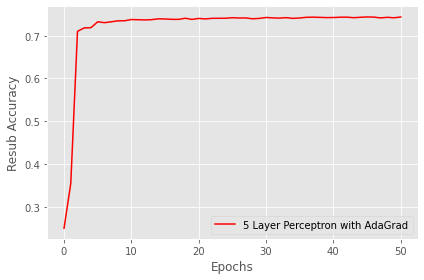

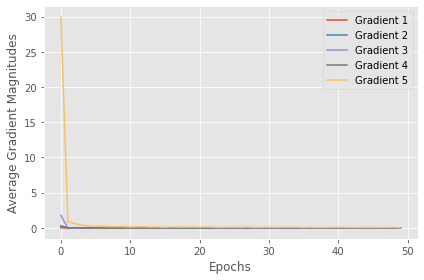

In [23]:
#use decrease_const as epsilon in AdaGrad formula
vals = { 'layers':5, 'n_hidden':30, 
         'C':0.1, 'epochs':50, 'eta':0.1, 
         'alpha':0.001, 'decrease_const':1e-12, 'minibatches':50,
         'shuffle':True,'random_state':1}

#quantify performance using accuracy
nn = AdaGradMLP(**vals)
%time gradients = nn.fit(X_train_norm_enc, y_train, print_progress=1)
#display accuracy performance and average gradient magnitudes for each layer
print_result(nn,X_train_norm_enc,y_train, X_test_norm_enc, y_test,gradients,title="5 Layer Perceptron with AdaGrad")

We chose the AdaGrad formula as our adaptive method in adaptive learning model. [The AdaGrad strategy is a stochastic optimization method that performs smaller updates for parameters associated with frequently occurring features, and larger updates for parameters associated with infrequently occurring features.](https://paperswithcode.com/method/adagrad) Both models were close in accuracy performance, but the AdaGrad model barely outperformed the model without an adaptive learning strategy by about .01% - .05%. It's worth noting that the gradient magnitudes converge at a faster rate with the AdaGrad adaptive method.

## 4. Exceptional Work

In [24]:
class AdaM_MLP(MLPBetterInitial):      
    def __init__(self, beta1=0.9, beta2=0.999, epsilon=1e-8, **kwds):        
        #adam decay rate of moment
        self.beta1 = beta1; self.beta2 = beta2
        #adam numerical stabilizer
        self.epsilon = epsilon
        super().__init__(**kwds)
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W = self._initialize_weights()
        
        self.cost_ = []
        self.score_ = []
        #get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        self.avg_grads_ = []
        for _ in range(self.layers):
            self.avg_grads_.append([])
        
        #AdaM variables
        V_k = []; M_k = []
        for w in self.W:
            V_k.append(np.zeros(w.shape))
            M_k.append(np.zeros(w.shape))
        M_prev = 0; V_prev = 0
        
        for i in range(self.epochs):
            grads = []
            for _ in range(self.layers):
                grads.append([])
            
            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            
            for idx in mini:

                # feedforward
                A, Z = self._feedforward(X_data[idx], self.W)
                cost = self._cost(A, Y_enc[:, idx], self.W)
                mini_cost.append(cost)

                # compute gradient via backpropagation
                gradients = self._get_gradient(A, Z, Y_enc[:, idx], self.W)
                
                # get average magnitude of the gradient for each layer
                for index in range(len(gradients)):
                    grads[index].append(np.mean(gradients[index]))
                    
                # implementing AdaM and updating weights [1]
                beta1_pow = self.beta1 ** (i + 1); beta2_pow = self.beta2 ** (i + 1)
                for index in range(len(gradients)):
                    grads[index].append(np.mean(gradients[index]))
                    g_sqr = np.square(gradients[index])
                    if i == 0:
                        M_k[index] = (1-self.beta1) * gradients[index]
                        V_k[index] = (1-self.beta2) * g_sqr
                    else:
                        M_tmp = (1-self.beta1) * gradients[index]
                        M_k[index] = (self.beta1 * M_prev[index]) + M_tmp
                        V_tmp = (1-self.beta2) * g_sqr
                        V_k[index] = (self.beta2 * V_prev[index]) + V_tmp
                        
                    M_k_hat = M_k[index] / (1-beta1_pow)
                    V_k_hat = V_k[index] / (1 - beta2_pow)
                    div_var = M_k_hat / np.sqrt(V_k_hat + self.epsilon)
                    
                    self.W[index] -= np.multiply(self.eta, div_var) 
                
                M_prev = M_k; V_prev = V_k
                
            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))

            for i in range(len(self.avg_grads_)):
                self.avg_grads_[i].append(np.mean(grads[i]))
        
        return self

Epoch: 40/40

CPU times: total: 1min 52s
Wall time: 9.43 s
5 Layer Perceptron with AdaM :
Resubstitution acc: 0.7435452263897961
Validation acc: 0.7323294829482948


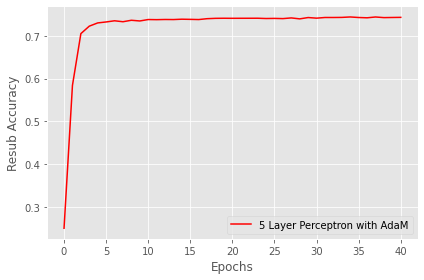

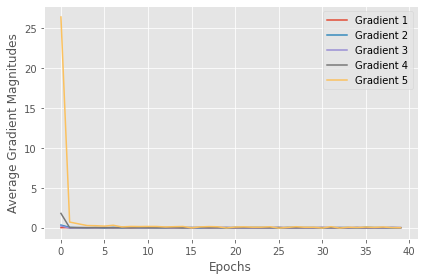

In [25]:
# 'h_hidden':[] will result in 30 neurons for each hidden layer
vals = {'layers':5, 'n_hidden':30, 'C':0.01, 'epochs':40, 'epsilon':1e-12,
        'eta':0.01, 'minibatches':50, 'shuffle':True, 'random_state':1}

nn_adam = AdaM_MLP(**vals)
%time nn_adam.fit(X_train_norm_enc, y_train, print_progress=1)
gradients = nn_adam.avg_grads_
print_result(nn_adam, X_train_norm_enc, y_train, X_test_norm_enc, y_test,gradients,title="5 Layer Perceptron with AdaM")
plt.show()

We see a clear improvement when utilizing AdaM in both our Resubstitution and Validation accuracies over our implementation of AdaGrad.
References

[1] <div class="csl-entry">Kingma, D. P., &#38; Ba, J. (2014). <i>Adam: A Method for Stochastic Optimization</i>.